# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [1]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

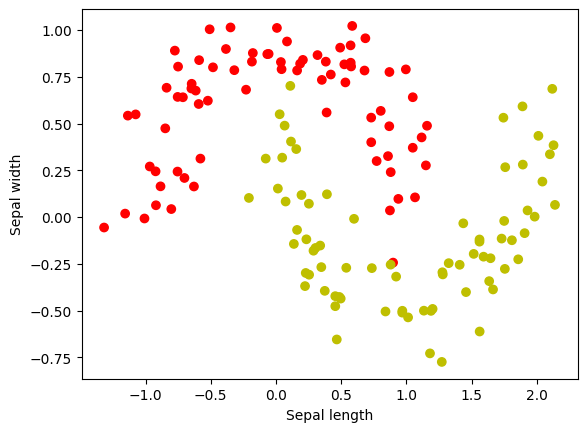

In [2]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [4]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [5]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [6]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [7]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0088)


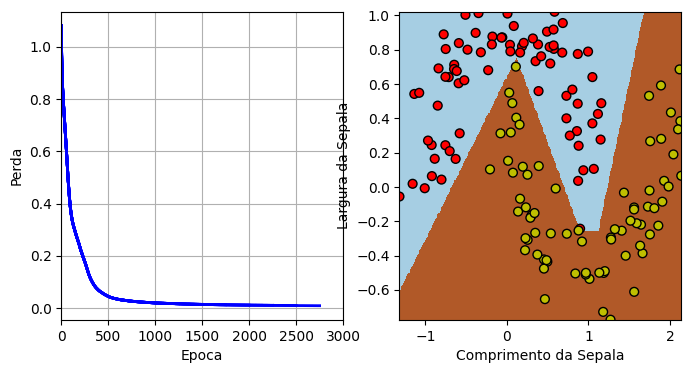

In [8]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [9]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[ 1.8291, -0.8159],
        [-3.2307,  0.4500],
        [-0.3376, -0.1081],
        [-1.8667, -1.4388],
        [ 0.0784, -0.2855]])
dense.0.bias    torch.Size([5])
tensor([-1.8539,  0.0411, -0.5002,  1.6956, -0.2967])
dense.2.weight  torch.Size([5, 5])
tensor([[-0.4193,  0.1777, -0.2645, -0.3871,  0.4455],
        [-1.0752,  1.3935,  0.4188, -1.0654,  0.2983],
        [ 1.2749, -1.2435,  0.1570,  1.8803, -0.3627],
        [-2.0109,  2.6179,  0.4442, -1.8424,  0.2877],
        [-0.3889,  0.2675,  0.4366, -0.0858, -0.4023]])
dense.2.bias    torch.Size([5])
tensor([-0.2021,  0.8584,  0.7326,  1.6636, -0.3890])
dense.4.weight  torch.Size([3, 5])
tensor([[-0.4049,  1.6571, -1.2052,  3.2270, -0.1166],
        [ 0.0790, -1.4600,  2.3844, -2.4693,  0.4062],
        [-0.3398, -0.0100, -0.2830, -0.6556, -0.4449]])
dense.4.bias    torch.Size([3])
tensor([ 0.3346,  1.8975, -1.9620])


### Avaliação do classificador

In [10]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


### Matriz de confusão

In [11]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,0
1,0,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.

In [12]:
# Modelo modificado - com maior quantidade de neurônios e camadas
class Modelo_v2(nn.Module):
    def __init__(self):
        super(Modelo_v2, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 10),   # mais neurônios na 1ª camada
            nn.ReLU(),
            nn.Linear(10, 8),   # camada intermediária extra
            nn.ReLU(),
            nn.Linear(8, 6),    # outra camada oculta
            nn.ReLU(),
            nn.Linear(6, 3)     # saída (3 classes)
        )

    def forward(self, x):
        return self.dense(x)

model = Modelo_v2()
print(model)

Modelo_v2(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=6, bias=True)
    (5): ReLU()
    (6): Linear(in_features=6, out_features=3, bias=True)
  )
)


Final loss: tensor(0.0058)


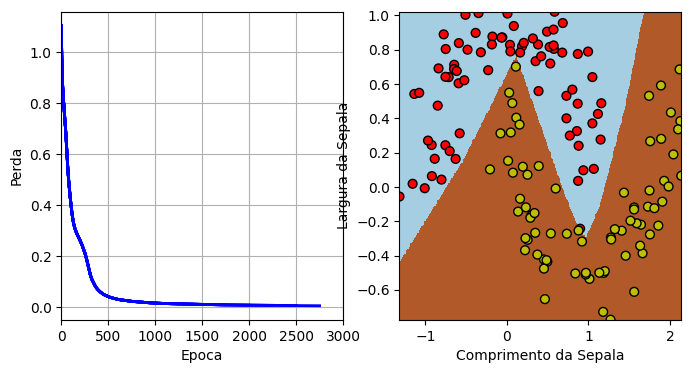

In [13]:
# plotagem do gráfico p/ análise
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# ==== Treino e plot ====

boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)
boundary_plot.on_train_begin()

losses = []

for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

Final loss: tensor(0.0031)


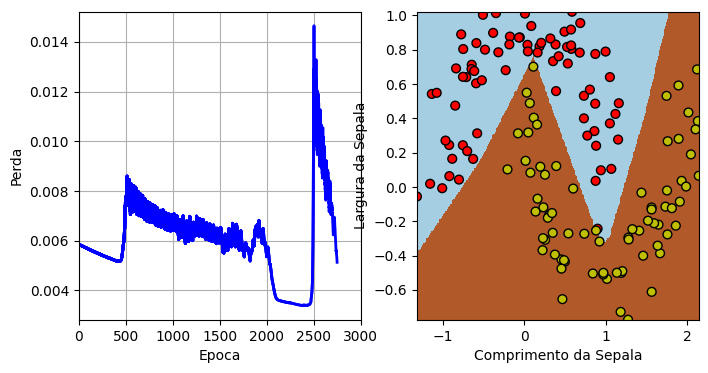

In [14]:
# plotagem do gráfico p/ análise
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# ==== Treino e plot ====

boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)
boundary_plot.on_train_begin()

losses = []

for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

* Com mais camadas e neurônios, a rede ganha maior capacidade de representação, podendo modelar fronteiras de decisão mais complexas.

* Entretanto, isso aumenta o custo computacional e pode levar ao overfitting se o conjunto de dados for pequeno (como o Iris).

* Visualmente (na fronteira de decisão), você deve notar contornos mais suaves e precisos, mas às vezes também oscilações desnecessárias (superajuste).

2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.

In [15]:
# modelo sigmoid
class Modelo_v2_sigmoid(nn.Module):
    def __init__(self):
        super(Modelo_v2_sigmoid, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.dense(x)

model = Modelo_v2_sigmoid()
print(model)

Modelo_v2_sigmoid(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


Final loss: tensor(0.2875)


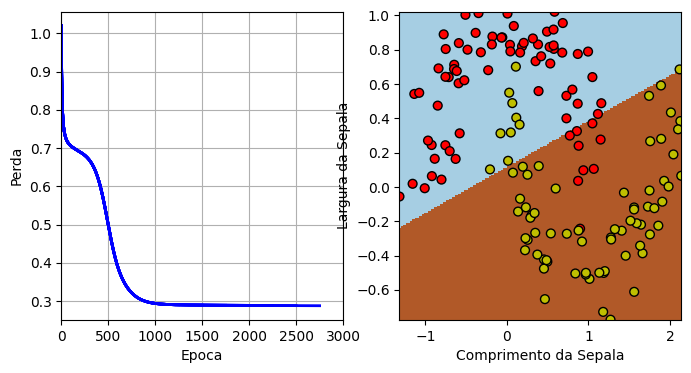

In [16]:
# plotagem do gráfico p/ análise
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# ==== Treino e plot ====

boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)
boundary_plot.on_train_begin()

losses = []

for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

* A Sigmoid comprime os valores entre 0 e 1, o que pode causar o problema do gradiente desaparecer em redes mais profundas.

* O treinamento fica mais lento e a rede pode ter dificuldade em ajustar fronteiras complexas.

* Em contrapartida, ela gera saídas mais suaves, o que pode ser útil em tarefas mais simples.

* Comparando com a ReLU, o aprendizado com Sigmoid tende a convergir mais lentamente e atingir acurácia menor no Iris dataset.

3. O que ocorre quando não se utiliza ativação não linear entre camadas?

In [17]:
class ModeloV4(nn.Module):
    def __init__(self):
        super(ModeloV4, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 5),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.dense(x)

model = ModeloV4()
print(model)

ModeloV4(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=3, bias=True)
  )
)


Final loss: tensor(0.2817)


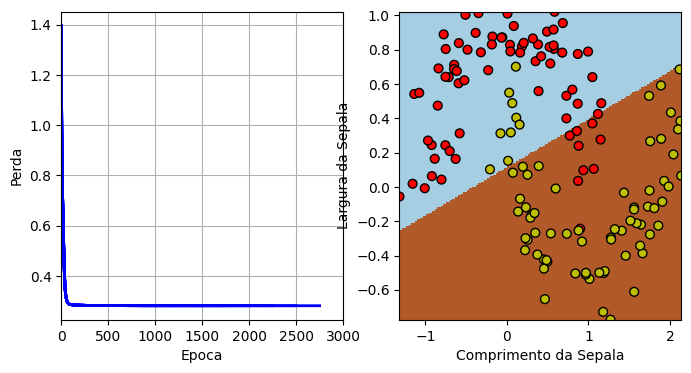

In [18]:
# plotagem do gráfico p/ análise
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# ==== Treino e plot ====

boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)
boundary_plot.on_train_begin()

losses = []

for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

* Sem funções de ativação a rede se comporta como um modelo linear, independentemente do número de camadas.

* Na prática, ela equivale a uma única camada linear, pois a composição de funções lineares continua sendo linear.

* Assim, a rede não consegue separar classes que não sejam linearmente separáveis (ex.: fronteiras curvas).

* O resultado visualmente mostra fronteiras retas e baixa acurácia.

## Principais aprendizados

Neste notebook, exploramos o uso de redes neurais para classificação no Iris dataset, analisando o impacto de diferentes configurações da arquitetura:

* Número de camadas e neurônios: aumentar a complexidade melhora a capacidade de modelar padrões, mas pode causar overfitting.

* Função de ativação: a ReLU favorece o aprendizado rápido e eficiente, enquanto a Sigmoid é mais estável, porém limitada em redes profundas.

* Ativação não linear: é essencial para que a rede aprenda relações não lineares; sem ela, o modelo perde poder de generalização.

* O estudo reforça a importância de balancear profundidade, ativação e regularização para obter bom desempenho e estabilidade no treinamento.